# Calculate location colours
The colours for locations are calcuated and stored as a YAML file.

## Imports

In [1]:
from ag3 import release_data
ag3_data = release_data()

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import cartopy as cart
import cartopy.crs as ccrs
import matplotlib.patches as patches
import numpy as np

In [3]:
# REQUIRES: https://pypi.org/project/colormath/
# pip install colormath
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color 

## Settings

In [4]:
output_path = 'location_colours.yaml'
centre_at_equator = False

## Functions

In [5]:
def latlong_to_rgb_hex_via_lab(lat, long, min_lat=-90, max_lat=90, min_long=-180, max_long=180, centre_at_equator=False, centre_at_prime_meridian=False):
    
    # 0 <= lightness < 100
    # NOTE: this affects extent of a & b (a_max, b_max)
    # TODO: determine what determines this limit, found by trial and error
    #lightness = 0; a_max = 243; b_max = 162
    lightness = 50; a_max = 93; b_max = 77
    #lightness = 99; a_max = 1; b_max = 1
    
    observer = '2' # Observer angle: default '2', alternative '10' degrees
    illuminant = 'd50' # default 'd50'
    # When observer '2', illuminant can have {'a', 'b', 'c', 'd50', 'd55', 'd65', 'd75', 'e', 'f2', 'f7', 'f11'}
    # When observer '10', illuminant can have {'d50', 'd55', 'd65', 'd75'}
    
    # TODO: option to centre on equator and/or the prime meridian
    if centre_at_equator:
        if -min_lat > max_lat:
            min_lat = -max_lat

    if centre_at_prime_meridian:
        if -min_long > max_long:
            min_Long = -max_long
     
    # Scale the lat-long 0 to 1, relative to the specified min and max
    lat_extent = max_lat - min_lat
    long_extent = max_long - min_long
    scaled_lat = (lat + abs(min_lat)) / lat_extent
    scaled_long = (long + abs(min_long)) / long_extent

    # Convert to range -1 to 1
    a = (scaled_lat * 2) - 1
    b = (scaled_long * 2) - 1

    # Convert to range
    a = a * a_max
    b = b * b_max
        
    # Switch depending on supplied param type
    if isinstance(lat, int):
        lab = LabColor(lightness, a, b)
        #xyz = convert_color(lab, XYZColor)
        #rgb = convert_color(xyz, sRGBColor)
        rgb = convert_color(lab, sRGBColor)
        rgb_hex = rgb.get_rgb_hex()
        return rgb_hex
    elif isinstance(lat, pd.core.series.Series):
        # TODO: vectorize
        rgb_hex = []
        for i in range(len(lat)):
            lab = LabColor(lightness, a[i], b[i])
            #xyz = convert_color(lab, XYZColor)
            #rgb = convert_color(xyz, sRGBColor)
            rgb = convert_color(lab, sRGBColor)
            rgb_hex.append(rgb.get_rgb_hex())
        return rgb_hex
    else:
        raise ValueError('Unhandled parameter types')

## Spot check the lat-long colour conversion

In [6]:
spot_check_data = []
for lat in [-90, 0, 90]:
    for long in [-180, 0, 180]:
        spot = {'lat': lat, 'long': long, 'colour': latlong_to_rgb_hex_via_lab(lat, long, centre_at_equator=centre_at_equator)}
        spot_check_data.append(spot)
spot_check_df = pd.DataFrame(spot_check_data)
spot_check_df

,lat,long,colour
0,-90,-180,#009afb
1,-90,0,#009674
2,-90,180,#009500
3,0,-180,#007cfc
4,0,0,#777777
5,0,180,#8b7500
6,90,-180,#d300fe
7,90,0,#f7007c
8,90,180,#ff0000


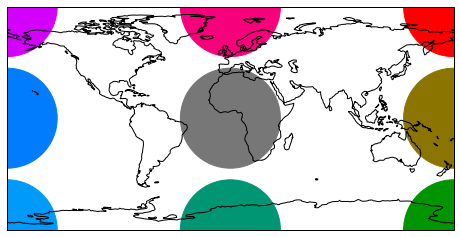

In [7]:
# Eyeball some lat-long to rgb_hex conversions
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

plt.scatter(spot_check_df["long"], spot_check_df["lat"], c=spot_check_df["colour"], s=100_00)
plt.show()

## Get the locations of all of the wild samples

In [8]:
wild_sample_meta = ag3_data.load_sample_set_metadata(ag3_data.all_wild_sample_sets)
wild_sample_meta.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True


In [9]:
# Check that there aren't different lat-longs for the same country-location
all_locations = wild_sample_meta[['country', 'location', 'latitude', 'longitude']]
unique_locations = all_locations.drop_duplicates(['country', 'location', 'latitude', 'longitude'])
duplicate_locations_by_lat_long = unique_locations.duplicated(['latitude', 'longitude'], keep=False)
unique_locations[duplicate_locations_by_lat_long]

,country,location,latitude,longitude
sample_id,,,,
AN0022-C,Cameroon,Gado Badzere,5.747,14.442
AN0061-Cx,Cameroon,Zembe Borongo,5.747,14.442
AN0585-CW,Cameroon,Manda,5.726,10.868
AN0499-CW,Cameroon,Mfelap,5.726,10.868


In [10]:
# TODO: Resolve/Explain these duplicate lat-longs

In [11]:
# We only need the unique locations
locations = wild_sample_meta[['country', 'location', 'latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
locations

,country,location,latitude,longitude
0,Angola,Luanda,-8.884,13.302
1,Burkina Faso,Pala,11.150,-4.235
2,Burkina Faso,Bana,11.233,-4.472
3,Burkina Faso,Souroukoudinga,11.235,-4.535
4,Burkina Faso,Monomtenga,12.060,-1.170
...,...,...,...,...
121,Tanzania,Moshi,-3.482,37.308
122,Tanzania,Tarime,-1.431,34.199
123,Tanzania,Muheza,-4.940,38.948
124,Uganda,Nagongera,0.770,34.026


## Calculate the location colours

In [12]:
locations['rgb_hex'] = latlong_to_rgb_hex_via_lab(locations['latitude'],
                                                  locations['longitude'],
                                                  min_lat=locations['latitude'].min(), max_lat=locations['latitude'].max(),
                                                  min_long=locations['longitude'].min(), max_long=locations['longitude'].max(),
                                                  centre_at_equator=centre_at_equator
                                                 )
locations

,country,location,latitude,longitude,rgb_hex
0,Angola,Luanda,-8.884,13.302,#4d807c
1,Burkina Faso,Pala,11.150,-4.235,#d600ca
2,Burkina Faso,Bana,11.233,-4.472,#d600cb
3,Burkina Faso,Souroukoudinga,11.235,-4.535,#d600cb
4,Burkina Faso,Monomtenga,12.060,-1.170,#e000bd
...,...,...,...,...,...
121,Tanzania,Moshi,-3.482,37.308,#947100
122,Tanzania,Tarime,-1.431,34.199,#a16a1c
123,Tanzania,Muheza,-4.940,38.948,#8a7500
124,Uganda,Nagongera,0.770,34.026,#b06220


## Check the location colours on a map

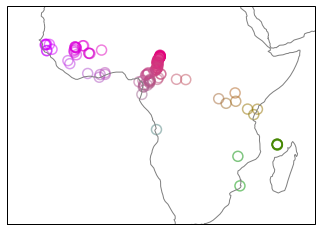

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines(color='grey')

xlim = ([locations["longitude"].min() - 10,  locations["longitude"].max() + 10])
ylim = ([locations["latitude"].min() - 10,  locations["latitude"].max() + 10])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.scatter(locations["longitude"], locations["latitude"], edgecolors=locations["rgb_hex"], alpha=0.5, s=100, color='None', linewidth=1.5)

plt.show()

## Make a reference colour map

In [14]:
# Generate lat-longs limited to the range of collection sites
min_lat = locations["latitude"].min()
max_lat = locations["latitude"].max()
min_long = locations["longitude"].min()
max_long = locations["longitude"].max()

# TODO: use a less brutal method
ref_lat_longs = []
lat_step = 1
long_step = 1
for lat in np.arange(min_lat, max_lat, lat_step):
    for long in np.arange(min_long, max_long, long_step):
        ref_lat_longs.append({'lat': lat, 'long': long})
ref_lat_longs[0]

{'lat': -23.715999999999998, 'long': -16.033}

In [15]:
# Add the generated lat-longs to a DataFrame, for convenience
ref_locations_df = pd.DataFrame(data=ref_lat_longs, columns=['lat', 'long'])
ref_locations_df.head()

,lat,long
0,-23.716,-16.033
1,-23.716,-15.033
2,-23.716,-14.033
3,-23.716,-13.033
4,-23.716,-12.033


In [16]:
# Get the colours for the lat-longs
ref_locations_df['rgb_hex'] = latlong_to_rgb_hex_via_lab(ref_locations_df['lat'],
                                                            ref_locations_df['long'],
                                                            min_lat=min_lat, max_lat=max_lat,
                                                            min_long=min_long, max_long=max_long,
                                                            centre_at_equator=centre_at_equator
                                                           )
ref_locations_df.head()

,lat,long,rgb_hex
0,-23.716,-16.033,#009afb
1,-23.716,-15.033,#009af7
2,-23.716,-14.033,#009af2
3,-23.716,-13.033,#009aee
4,-23.716,-12.033,#0099e9


### Plot the coloured lat-longs on a map

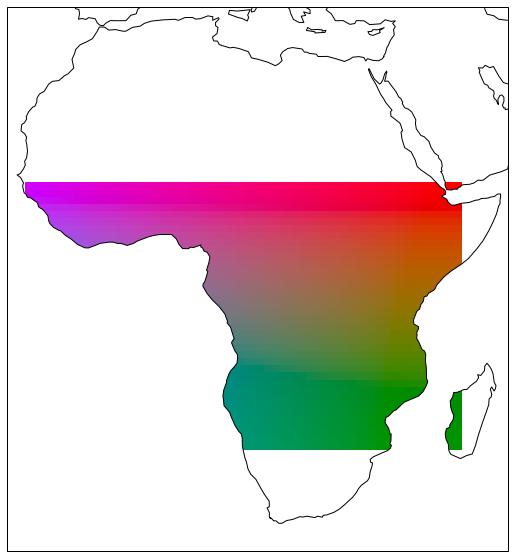

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

xlim = ([min_long - 3, max_long + 7]) # west, east (long)
ylim = ([min_lat - 15,  max_lat + 25]) # south, north (lat)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.add_feature(cart.feature.OCEAN, zorder=1, edgecolor='k', facecolor='white')
plt.scatter(ref_locations_df["long"], ref_locations_df["lat"], c=ref_locations_df["rgb_hex"], marker='s', s=50)

plt.show()

### Check the locations on the reference map

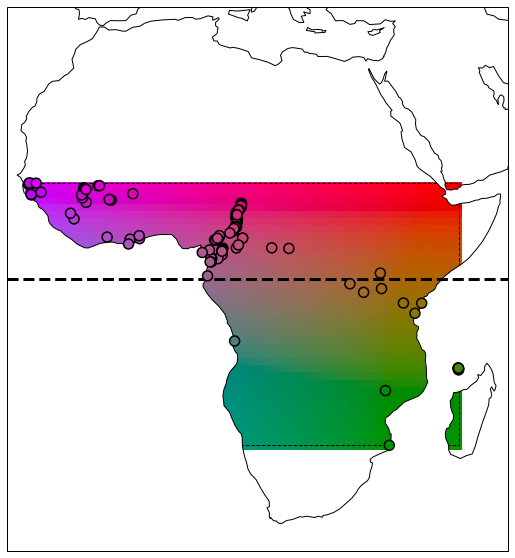

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

xlim = ([min_long - 3, max_long + 7]) # west, east (long)
ylim = ([min_lat - 15,  max_lat + 25]) # south, north (lat)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.add_feature(cart.feature.OCEAN, zorder=1, edgecolor='k', facecolor='white')
plt.scatter(ref_locations_df["long"], ref_locations_df["lat"], c=ref_locations_df["rgb_hex"], marker='s', s=50)
rect = patches.Rectangle(
    (min_long, min_lat), (max_long - min_long), (max_lat - min_lat),
    linewidth=1, edgecolor='black', facecolor='none', linestyle='--'
)
ax.add_patch(rect)
plt.plot([min_long - 3, max_long + 7], [0, 0], color='black', linewidth=3, marker='None', linestyle='--')
plt.scatter(locations["longitude"], locations["latitude"], c=locations["rgb_hex"], edgecolor='k', alpha=1, s=100, linewidth=1.5, zorder=3)

plt.show()

## Store the location colours as a file

In [19]:
# Get the location_labels and their corresponding rgb_hex colours
location_colours = locations[['country', 'location', 'rgb_hex']].set_index(['country', 'location'])
location_colours

rgb_hex
country      location               
Angola       Luanda          #4d807c
Burkina Faso Pala            #d600ca
             Bana            #d600cb
             Souroukoudinga  #d600cb
             Monomtenga      #e000bd
...                              ...
Tanzania     Moshi           #947100
             Tarime          #a16a1c
             Muheza          #8a7500
Uganda       Nagongera       #b06220
             Kihihi          #a46836

[126 rows x 1 columns]

### Convert the DataFrame values into a dictionary

In [20]:
# Note: Panda's to_dict(orient='index') converts multi-column index into a tuple,
# which isn't what we want for the YAML
#location_colours_as_dict = location_colours.to_dict(orient='index')
#list(location_colours_as_dict.keys())[0]
#ignore_index=True

In [21]:
# Compose the dict manually
location_colours_as_dict = {}
for country, country_group in location_colours.groupby('country'):
    location_colours_as_dict[country] = {}
    for location, location_group in country_group.groupby('location'):
        location_colours_as_dict[country][location] = location_group['rgb_hex'][0]

In [22]:
location_colours_as_dict.keys()

dict_keys(['Angola', 'Burkina Faso', 'Cameroon', 'Central African Republic', "Cote d'Ivoire", 'Democratic Republic of Congo', 'Equatorial Guinea', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Malawi', 'Mali', 'Mayotte', 'Mozambique', 'Tanzania', 'Uganda'])

In [23]:
location_colours_as_dict['Burkina Faso']

{'Bana': '#d600cb',
 'Monomtenga': '#e000bd',
 'Pala': '#d600ca',
 'Souroukoudinga': '#d600cb'}

### Write the dictionary to YAML

In [24]:
with open(output_path, 'w') as ymlfile:
    yaml.dump(location_colours_as_dict, ymlfile, sort_keys=True, allow_unicode=True)

## Check the location colours file

In [25]:
# Load the data from the YAML file
with open(output_path) as file:
    reloaded_data_dict = yaml.load(file, Loader=yaml.Loader)

In [26]:
reloaded_data_dict.keys()

dict_keys(['Angola', 'Burkina Faso', 'Cameroon', 'Central African Republic', "Cote d'Ivoire", 'Democratic Republic of Congo', 'Equatorial Guinea', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Malawi', 'Mali', 'Mayotte', 'Mozambique', 'Tanzania', 'Uganda'])

In [27]:
reloaded_data_dict['Burkina Faso']

{'Bana': '#d600cb',
 'Monomtenga': '#e000bd',
 'Pala': '#d600ca',
 'Souroukoudinga': '#d600cb'}

### Convert the dict into a DataFrame

In [28]:
# Note: Panda's from_dict() and from_records() don't interpret the dict in the way we want
#reloaded_df = pd.DataFrame.from_dict(reloaded_data_dict)
#reloaded_df.head()

In [29]:
# Compose the DataFrame manually
reloaded_df = pd.DataFrame(columns=['country', 'location', 'rgb_hex'])
for country in reloaded_data_dict.keys():
    for location in reloaded_data_dict[country].keys():
        reloaded_df = reloaded_df.append(
            {'country': country, 'location': location, 'rgb_hex': reloaded_data_dict[country][location]},
            ignore_index=True
        )
reloaded_df

,country,location,rgb_hex
0,Angola,Luanda,#4d807c
1,Burkina Faso,Bana,#d600cb
2,Burkina Faso,Monomtenga,#e000bd
3,Burkina Faso,Pala,#d600ca
4,Burkina Faso,Souroukoudinga,#d600cb
...,...,...,...
121,Tanzania,Muheza,#8a7500
122,Tanzania,Muleba,#9d6c2b
123,Tanzania,Tarime,#a16a1c
124,Uganda,Kihihi,#a46836


In [30]:
# Match the location labels with the lat longs we have
original_locations = locations[['country', 'location', 'longitude', 'latitude']]
recovered_locations = reloaded_df.merge(original_locations, on=['country', 'location'])
recovered_locations

,country,location,rgb_hex,longitude,latitude
0,Angola,Luanda,#4d807c,13.302,-8.884
1,Burkina Faso,Bana,#d600cb,-4.472,11.233
2,Burkina Faso,Monomtenga,#e000bd,-1.170,12.060
3,Burkina Faso,Pala,#d600ca,-4.235,11.150
4,Burkina Faso,Souroukoudinga,#d600cb,-4.535,11.235
...,...,...,...,...,...
121,Tanzania,Muheza,#8a7500,38.948,-4.940
122,Tanzania,Muleba,#9d6c2b,31.651,-1.962
123,Tanzania,Tarime,#a16a1c,34.199,-1.431
124,Uganda,Kihihi,#a46836,29.701,-0.751


### Eyeball the colours from the file on a map

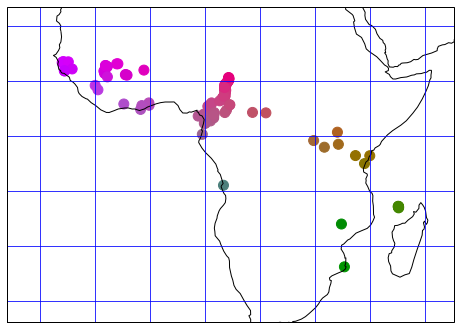

In [31]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

xlim = ([recovered_locations["longitude"].min() - 10,  recovered_locations["longitude"].max() + 10])
ylim = ([recovered_locations["latitude"].min() - 10,  recovered_locations["latitude"].max() + 10])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.gridlines(color='blue')
ax.coastlines()

plt.scatter(recovered_locations["longitude"], recovered_locations["latitude"], color=recovered_locations["rgb_hex"], s=100)

plt.show()

## Test `ag3.py` usage

In [32]:
import ag3
import importlib
importlib.reload(ag3)

<module 'ag3' from '/home/jovyan/gitRepos/ag1000g-phase3-data-paper/notebooks/ag3.py'>

In [33]:
imported_location_colours = ag3.release_data().location_colours
imported_location_colours['Cameroon'].keys()

dict_keys(['Afan-Essokye', 'Ahala', 'Avebe', 'Badankali', 'Badjawa', 'Balda Bouri', 'Bamendi', 'Banda', 'Beka Goto', 'Bini', 'Birsok', 'Campo', 'Carrefour Nari', 'Carrefour Poli', 'Daiguene', 'Djaba', 'Djamboutou', 'Djet', 'Dolla', 'Dombé', 'Douala', 'Doulougou', 'Essos', 'Foulassi I', 'Gada Mabanga', 'Gado Badzere', 'Gakle', 'Gamba', 'Gouna', 'Guijiba', 'Harr', 'Karba', 'Laf', 'Lagdo', 'Lainde Mbana', 'Lamoudan', 'Lougga Tapadi', 'Lougol', "Mabarangal'L", 'Makabay (Djarengo)', 'Mambang', 'Manchoutvi', 'Manda', 'Mangoum', 'Massila', 'Mawara', 'Mayo Boki', 'Mayo Dafan', 'Mayo Djarani', 'Mayo Lebride', 'Mayos', 'Mbalmayo', 'Mfelap', 'Mgbandji', 'Morongo', 'Moulva', 'Mounda', 'Moussourtouk', 'Ngaouya Nga', 'Nkolondom', 'Nlozok', 'Obala', 'Otibili', 'Palama', 'Rompo', 'Secamde', 'Sorawel', 'Séboré', 'Tchéré', 'Tekel', 'Tibati', 'Toumbouroum', 'Wouro Andre', 'Yaounde', 'Zembe Borongo'])

In [34]:
imported_location_colours['Cameroon']['Séboré']

'#df1c7e'